The dataset is collected from Scopus website using the export function.

The searching criteria is "Title-Abstract-Keywords: Multimodal AND Sentiment AND Analysis".

To prepare your own dataset, the necessary columns are "Title", "Abstract", and "Keywords".

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from pprint import pprint
import re
from gensim import corpora
import seaborn as sns
import numpy as np
from gensim.models import LdaModel, CoherenceModel

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yingq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yingq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yingq\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
papers = pd.read_csv('papers_data.csv')

print(f'Columns in the dataset: {papers.columns}')
print(f'Number of papers: {len(papers)}')
print(papers.describe())
papers.head()

Columns in the dataset: Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'Molecular Sequence Numbers', 'Chemicals/CAS',
       'Tradenames', 'Manufacturers', 'Funding Details', 'Funding Texts',
       'References', 'Correspondence Address', 'Editors', 'Publisher',
       'Sponsors', 'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')
Number of papers: 1883
              Year    Page count     Cited by  Molecular Sequence Numbers  \
count  1883.000000   1341.000000  1883.000000                   

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,ISBN,CODEN,PubMed ID,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Open Access,Source,EID
0,Zou W.; Sun X.; Lu Q.; Wang X.; Feng J.,"Zou, Wang (58497825600); Sun, Xia (56341695200...",58497825600; 56341695200; 57216037356; 5938823...,A vision and language hierarchical alignment f...,2025,Pattern Recognition,162,NaN,111369,NaN,...,NaN,PTNRA,NaN,English,Pattern Recogn.,Article,Final,NaN,Scopus,2-s2.0-85215442699
1,Wang H.; Du Q.; Xiang Y.,"Wang, Hongbing (59560002000); Du, Qifei (59560...",59560002000; 59560407900; 55836565000,Image–text sentiment analysis based on hierarc...,2025,Engineering Applications of Artificial Intelli...,146,NaN,110262,NaN,...,NaN,EAAIE,NaN,English,Eng Appl Artif Intell,Article,Final,NaN,Scopus,2-s2.0-85217967973
2,Zhang D.,"Zhang, Dingkai (57215547438)",57215547438,Pffm-se: a passenger flow forecasting model fo...,2025,Transportation,NaN,NaN,100122,NaN,...,NaN,NaN,NaN,English,Transportation,Article,Article in press,NaN,Scopus,2-s2.0-85218145146
3,Yang Z.; He Q.; Du N.; He Q.,"Yang, Zhihao (59503587400); He, Qing (57189500...",59503587400; 57189500080; 57222383453; 5897855...,Temporal text-guided feedback-based progressiv...,2025,Alexandria Engineering Journal,116,NaN,NaN,699,...,NaN,NaN,NaN,English,Alexandria Engineering Journal,Article,Final,NaN,Scopus,2-s2.0-85214321812
4,Xiu T.; Gao Y.; Sun Y.; Wu J.; Zhang X.; Zhang...,"Xiu, Taiyu (59559510300); Gao, Yunting (595603...",59559510300; 59560311300; 59560111200; 5955910...,The Analysis of Emotion-Aware Personalized Rec...,2025,Journal of Organizational and End User Computing,37,1,NaN,NaN,...,NaN,NaN,NaN,English,J. Organ. End User Comput.,Article,Final,NaN,Scopus,2-s2.0-85217951146


In [4]:
print("Missing values in each column:")
print(papers.isnull().sum())

# Drop columns where the proportion of missing values is greater than 30%
papers = papers.loc[:, papers.isnull().mean() <= 0.2]

Missing values in each column:
Authors                           206
Author full names                 206
Author(s) ID                      206
Title                               0
Year                                0
Source title                        0
Volume                            708
Issue                            1375
Art. No.                         1463
Page start                        729
Page end                          734
Page count                        542
Cited by                            0
DOI                               345
Link                                0
Affiliations                      208
Authors with affiliations         208
Abstract                            0
Author Keywords                   425
Index Keywords                    414
Molecular Sequence Numbers       1883
Chemicals/CAS                    1882
Tradenames                       1881
Manufacturers                    1881
Funding Details                  1037
Funding Texts      

In [5]:
# Remove DOI column as not necessary for analysis
papers = papers.drop(columns=['DOI'])
papers.dropna(inplace=True)
len(papers)


1650

In [6]:
def country_from_affiliation(affiliation):
    # Split the string by comma and extract the last element
    match = re.search(r'(\b\w+\b)\s*;', affiliation)
    if match:
        return match.group(1)
    else:
        # If no semicolon is found, return the last word in the text.
        words = re.findall(r'\b\w+\b', text)
        return words[-1] if words else None


text = "Faculty of Information Engineering and Automation, Kunming University of Science and Technology, Yunnan, Kunming, 650500, China; School of Computer Science and Technology, Yunnan University, Yunnan, Kunming, 650091, China"
print(country_from_affiliation(text))
papers['Country'] = papers['Affiliations'].apply(country_from_affiliation)

China


In [ ]:
def get_main_insitution(affiliation):
    # 1) Take only the first chunk (in case there are multiple separated by semicolons).
    first_chunk = affiliation.split(';')[0].strip()

    keywords = [
        'University', 'College', 'School', 'Institute', 'Academy',
        'Laboratory', 'Lab', 'Center', 'Centre'
    ]

    # 3) Build a regex pattern to capture a phrase that includes at least one of the keywords.
    #    - Starts with a capital word (e.g., "London" or "Faculty")
    #    - Possibly followed by more words or connectors (of / and / in / for / etc.)
    #    - Ends in one of the keywords, and can continue with "of ...", "and ...", etc.
    #
    #    Example match: "London School of Economics and Political Science"
    #    Example match: "Kunming University of Science and Technology"
    #
    #    Explanation:
    #    - [A-Z][a-zA-Z&.\'-]+ : A capital letter followed by letters, &, ., ', or - (a naive "word" with possible punctuation)
    #    - (?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))* : zero or more groups of spaces plus either "of/and/in/for" or another capitalized word
    #    - (?:University|College|School|Institute|Academy|Laboratory|Lab|Center|Centre) : the institution keyword
    #    - (?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))* : optionally more words/connectors after the keyword
    #
    pattern_str = (
        r'([A-Z][a-zA-Z&.\'-]+'
        r'(?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))*\s+'
        r'(?:' + '|'.join(keywords) + r')'
        r'(?:\s+(?:of|and|in|for|[A-Z][a-zA-Z&.\'-]+))*)'
    )
    pattern = re.compile(pattern_str)
    
    # 4) Search in the first chunk
    match = pattern.search(first_chunk)
    if match:
        # Return the matched institution phrase
        return match.group(1).strip()
    else:
        # Fallback: if no match, return the entire first chunk
        return first_chunk
    
text = "School of Computer Science, Monash University, Melbourne, VIC 3800, Australia"
print(get_main_insitution(text))
papers['Institution'] = papers['Affiliations'].apply(get_main_insitution)



Monash University


In [8]:
def extract_first_author(text):
    # Split the string by comma and extract the first element
    return text.split(';')[0].strip()

papers['First Author'] = papers['Authors'].apply(extract_first_author)

Analyzing trends and patterns in the research paper data for exploration and visualization

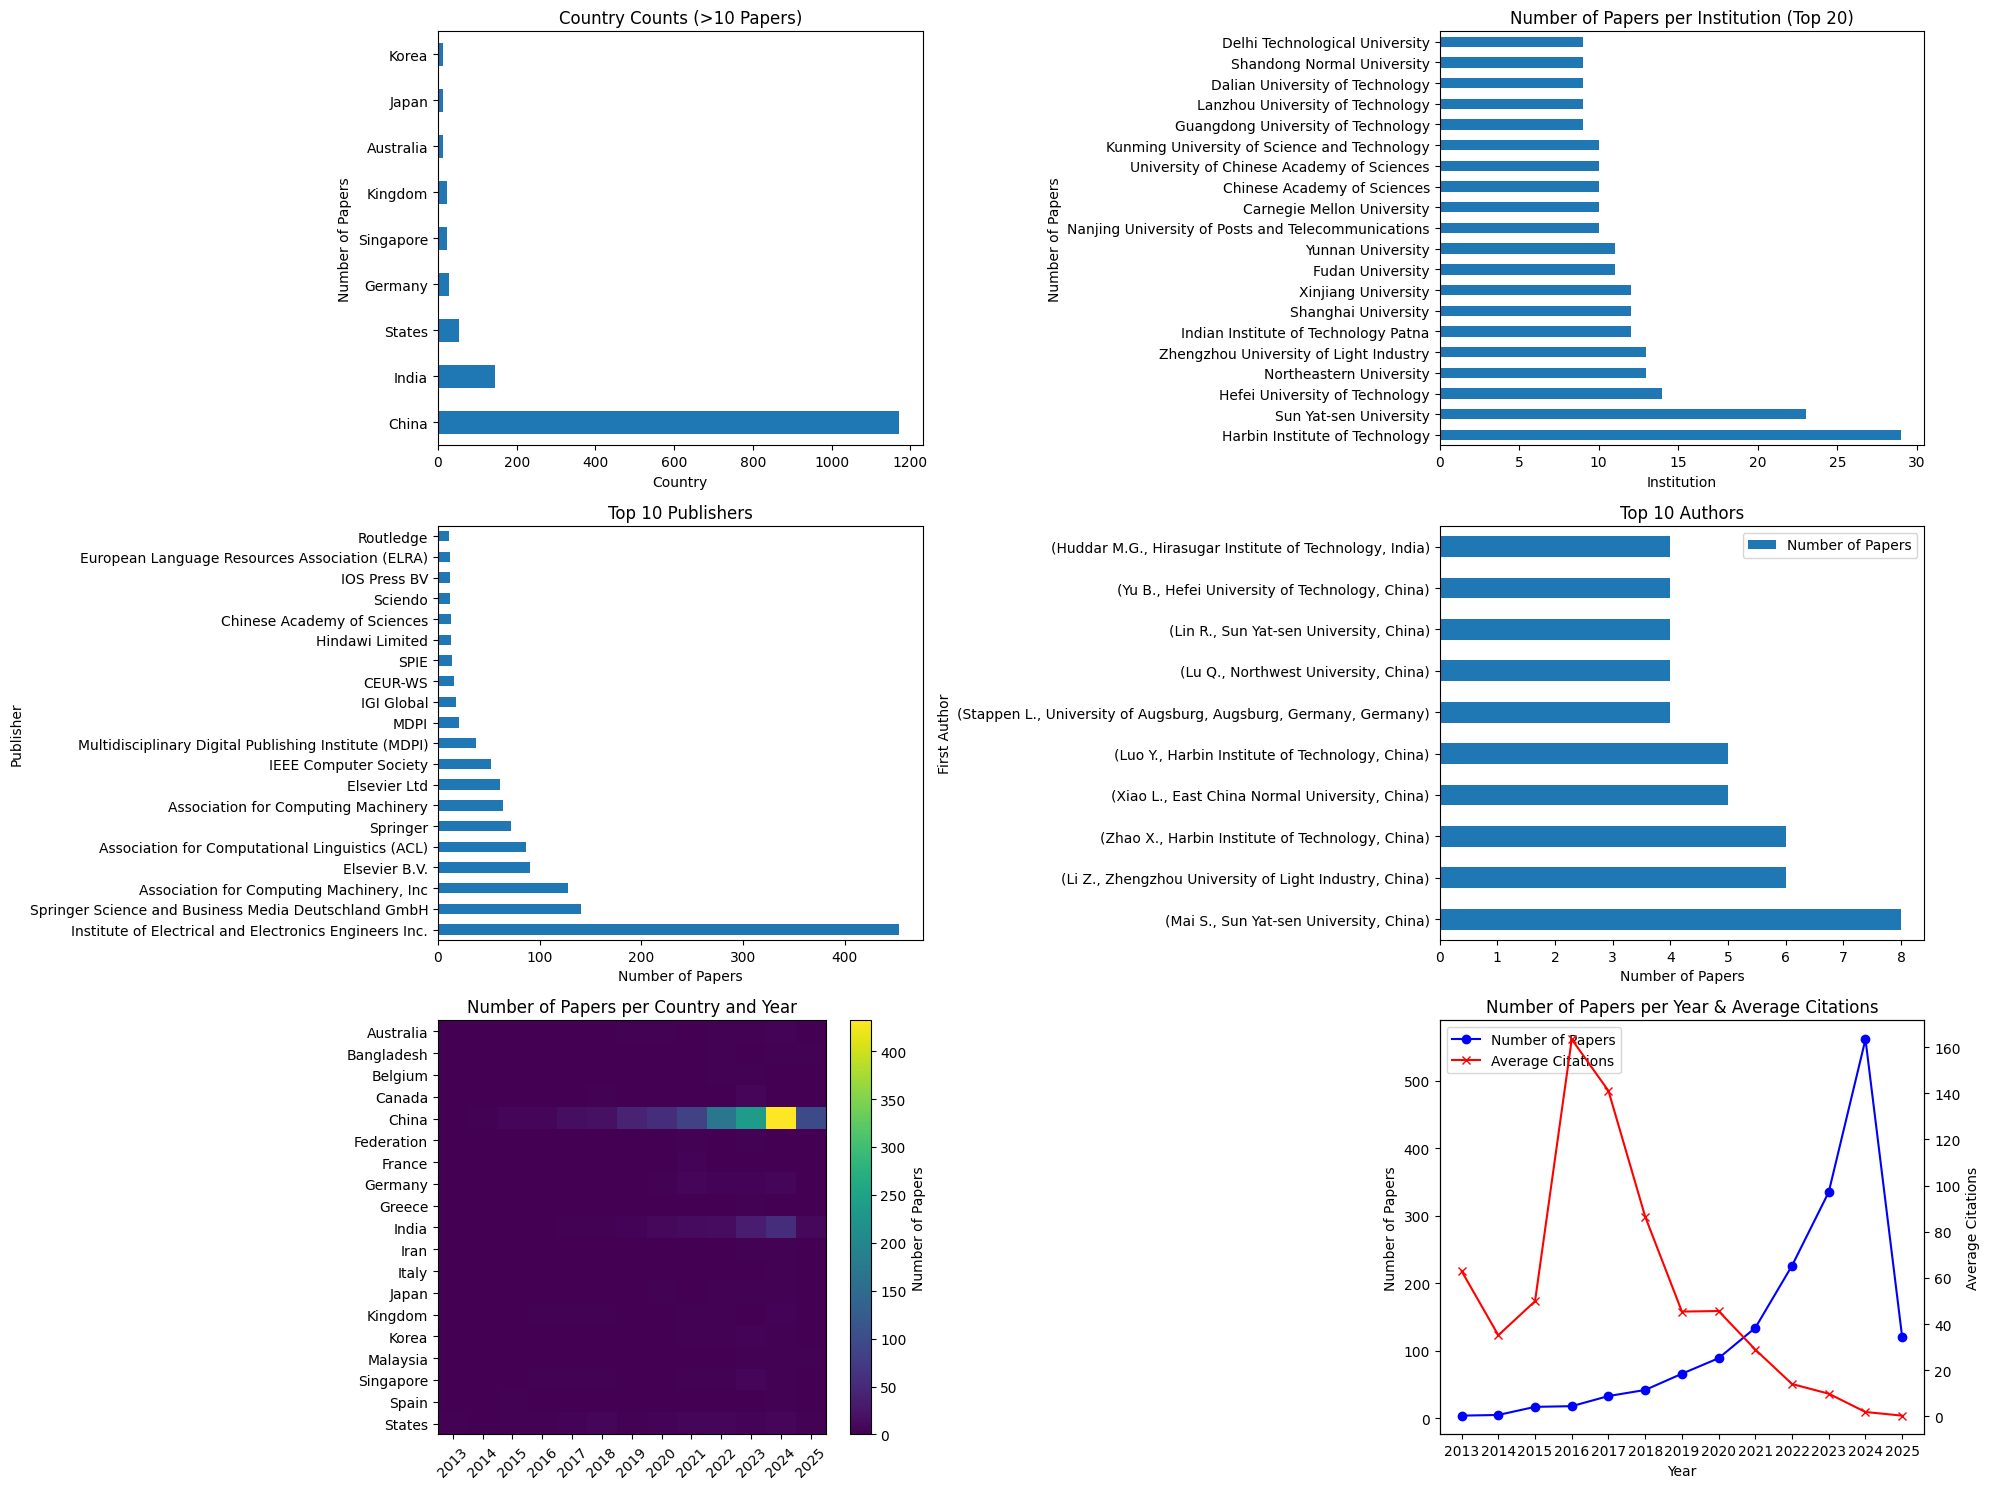

In [9]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs = axs.flatten()  # Flatten to simplify indexing

# 1. Plot: Country counts (>10 papers)
country_counts = papers['Country'].value_counts()
country_counts = country_counts[country_counts > 10]
country_counts.plot(kind='barh', ax=axs[0])
axs[0].set_title('Country Counts (>10 Papers)')
axs[0].set_xlabel('Country')
axs[0].set_ylabel('Number of Papers')

# 2. Plot: Institution counts (Top 20)
institution_counts = papers['Institution'].value_counts().sort_values(ascending=False)[:20]
institution_counts.plot(kind='barh', ax=axs[1])
axs[1].set_title('Number of Papers per Institution (Top 20)')
axs[1].set_xlabel('Institution')
axs[1].set_ylabel('Number of Papers')

# 3. Plot: Top 10 Publishers
publisher = papers['Publisher'].value_counts().sort_values(ascending=False)[:20]
publisher.plot(kind='barh', ax=axs[2])
axs[2].set_title('Top 10 Publishers')
axs[2].set_xlabel('Number of Papers')
axs[2].set_ylabel('Publisher')

# 4. Plot: Top 10 Authors (by first author and institution)
author_count = papers.groupby(['First Author', 'Institution', 'Country'])['First Author']\
                     .count().sort_values(ascending=False)[:10]
author_count.plot(kind='barh', ax=axs[3])
axs[3].set_title('Top 10 Authors')
axs[3].set_xlabel('Number of Papers')
axs[3].set_ylabel('First Author')
axs[3].legend(['Number of Papers'])

# 5. Plot: Heatmap of papers per country and year
country_year_counts = papers.groupby(['Country', 'Year']).size().unstack().fillna(0)
country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 5]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
im = axs[4].imshow(country_year_counts, aspect='auto')
axs[4].set_title('Number of Papers per Country and Year')
axs[4].set_yticks(range(len(country_year_counts)))
axs[4].set_yticklabels(country_year_counts.index)
axs[4].set_xticks(range(len(country_year_counts.columns)))
axs[4].set_xticklabels(country_year_counts.columns, rotation=45)
fig.colorbar(im, ax=axs[4], label='Number of Papers')

# 6. Plot: Number of papers per year and average citations
count = papers.groupby('Year').count()
avg_cite = papers.groupby('Year')['Cited by'].mean()
# Plot number of papers on the primary y-axis
count.plot(y='Title', ax=axs[5], label='Number of Papers', color='blue', marker='o')
axs[5].set_title('Number of Papers per Year & Average Citations')
axs[5].set_xticks(count.index)
axs[5].set_xlabel('Year')
axs[5].set_ylabel('Number of Papers')
# Create a secondary y-axis for average citations
ax2 = axs[5].twinx()
avg_cite.plot(ax=ax2, label='Average Citations', color='red', marker='x')
ax2.set_ylabel('Average Citations')
# Combine legends from both axes
lines1, labels1 = axs[5].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[5].legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


## Prprocess natural language data

In [12]:

papers['Abstract'] = papers['Abstract'].str.lower()

papers['Abstract'] = papers.Abstract.apply(nltk.word_tokenize)

papers['Abstract'] = papers.Abstract.apply(lambda x: [item for item in x if item.isalpha()])

stop_words = set(stopwords.words('english'))
papers['Abstract'] = papers.Abstract.apply(lambda x: [item for item in x if item not in stop_words])

lemmatizer = WordNetLemmatizer()
papers['Abstract'] = papers.Abstract.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])


bigram = gensim.models.Phrases(papers['Abstract'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(papers['Abstract'], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
papers['Abstract'] = make_bigrams(papers['Abstract'])
papers['Abstract'] = make_trigrams(papers['Abstract'])
papers.reset_index(drop=True, inplace=True)
word_lists = [papers['Abstract'][i] for i in range(len(papers))]
id2word = corpora.Dictionary(word_lists)

corpus = [id2word.doc2bow(word) for word in word_lists]


# Find the optimal number of topics using coherence score



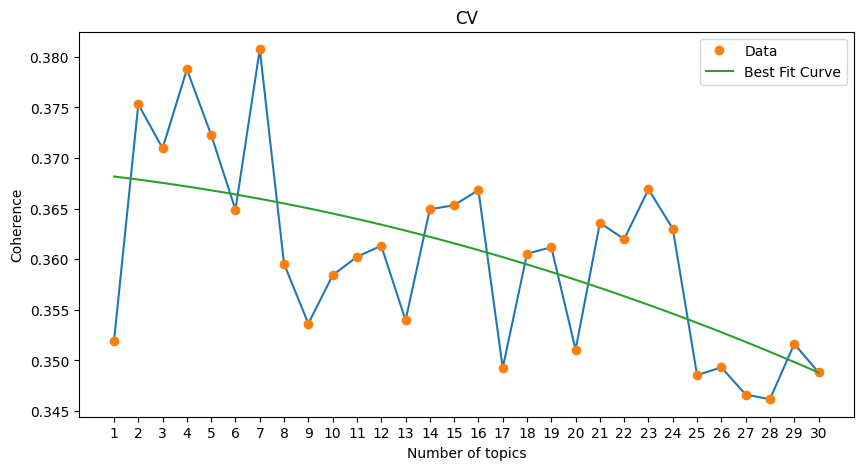

In [13]:

topic_count = [i for i in range(1, 31)]
perplexity = []
coherence_cv = []
coherence_umass = []
for i in topic_count:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, random_state=100, passes=20, chunksize=len(corpus), alpha='auto', eta='auto')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_lists, dictionary=id2word, coherence='c_v')
    coherence_cv.append(coherence_model_lda.get_coherence())

plt.figure(figsize=(10,5))
plt.plot(topic_count, coherence_cv)
plt.xlabel('Number of topics')
# Fit a polynomial curve to the data
coefficients = np.polyfit(topic_count, coherence_cv, 2)
poly = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(min(topic_count), max(topic_count), 100)

# Plot the curve
plt.plot(topic_count, coherence_cv, 'o', label='Data')
plt.plot(x, poly(x), label='Best Fit Curve')

plt.xlabel('Number of topics')
plt.xticks(topic_count)
plt.ylabel('Coherence')
plt.title('CV')
plt.legend()
plt.show()



## Perform topic modelling, show the probability of each topic and the word cloud for each topic

#### Analyze the topics type using the word cloud


In [23]:
papers.columns

Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Cited by', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'References', 'Publisher',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Source', 'EID', 'Country',
       'Institution', 'First Author'],
      dtype='object')

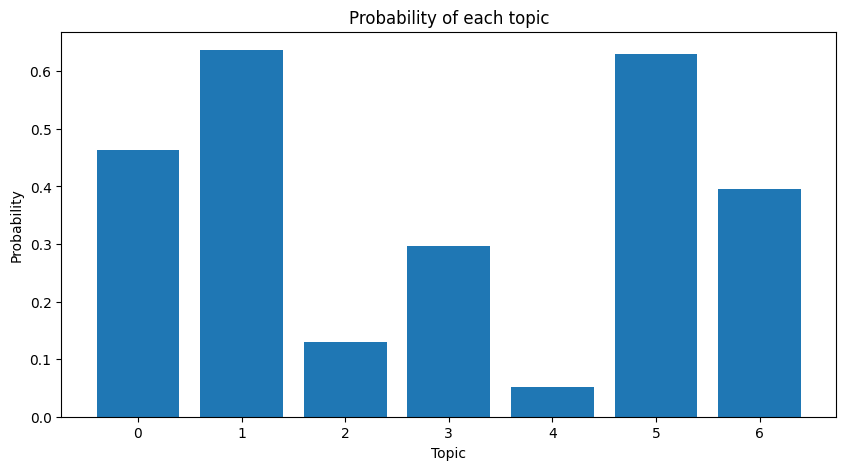

Keywords For Each Topic
[(0, '0.017*"analysis" + 0.015*"sentiment" + 0.013*"data" + 0.010*"model" + 0.008*"study" + 0.008*"multimodal" + 0.007*"approach" + 0.007*"learning" + 0.007*"user" + 0.007*"social"'), (1, '0.029*"feature" + 0.025*"model" + 0.023*"sentiment" + 0.022*"multimodal" + 0.018*"analysis" + 0.015*"emotion" + 0.013*"fusion" + 0.012*"data" + 0.011*"information" + 0.010*"network"'), (2, '0.018*"task" + 0.015*"humor" + 0.011*"language" + 0.011*"meme" + 0.008*"emotion" + 0.007*"detection" + 0.007*"dataset" + 0.006*"medium" + 0.006*"sentiment" + 0.006*"corpus"'), (3, '0.044*"sentiment" + 0.032*"analysis" + 0.025*"multimodal" + 0.016*"emotion" + 0.010*"modality" + 0.009*"research" + 0.009*"datasets" + 0.007*"method" + 0.007*"data" + 0.007*"dataset"'), (4, '0.017*"video" + 0.008*"prediction" + 0.008*"short" + 0.008*"rating" + 0.008*"viewer" + 0.007*"advertisement" + 0.005*"global" + 0.005*"comment" + 0.004*"product" + 0.004*"participant"'), (5, '0.036*"multimodal" + 0.034*"modal

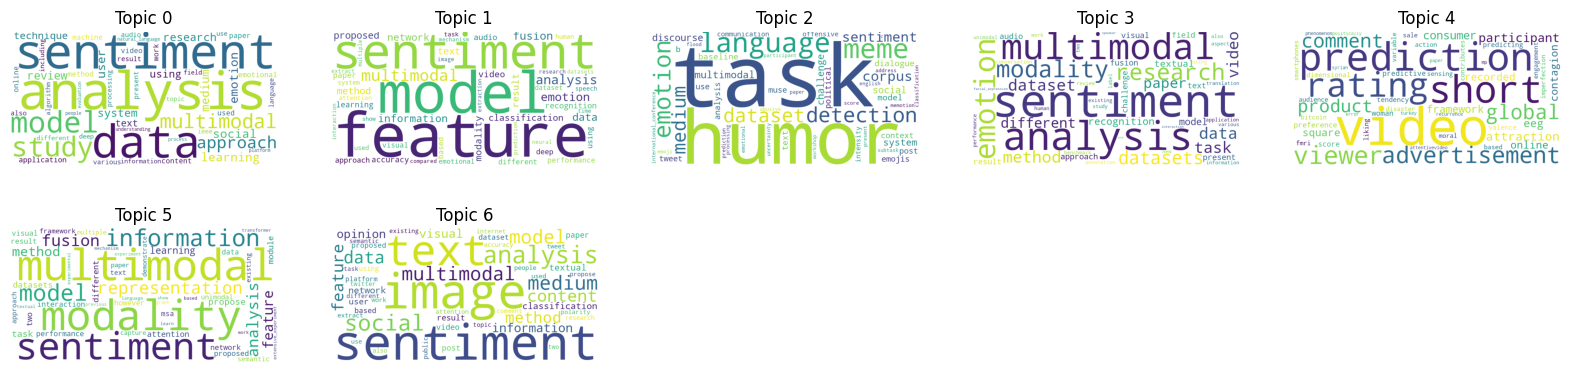

In [24]:


number_of_topics = 7

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=number_of_topics,chunksize=1000, alpha='auto', eta='auto', random_state=100, passes=10)
all_topics = lda_model.print_topics()

docs_per_topic = [[] for _ in range(lda_model.num_topics)]

for doc_id, doc_bow in enumerate(corpus):
    doc_topics = lda_model.get_document_topics(doc_bow)
    for topic, prob in doc_topics:
        docs_per_topic[topic].append((doc_id, prob))

count_per_topic = [len(topic) for topic in docs_per_topic]
probabilities_per_topic = [len(topic)/len(word_lists) for topic in docs_per_topic]

plt.figure(figsize=(10,5))
plt.bar(range(len(probabilities_per_topic)),probabilities_per_topic)
plt.xticks(range(len(probabilities_per_topic)))
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Probability of each topic')
plt.show()

print("Keywords For Each Topic")
print(lda_model.print_topics(num_topics=lda_model.num_topics))

from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = [20, 20]



wc = WordCloud(background_color='white',width=800, height=400)
for i in range(lda_model.num_topics):
    plt.subplot(8,5,i+1)
    wc = WordCloud(background_color='white',width=800, height=400)
    plt.imshow(wc.fit_words(dict(lda_model.show_topic(i,50))))
    plt.title('Topic {}'.format(i))
    plt.axis('off')

top_doc_per_topic = [sorted(topic, key=lambda x:x[1], reverse=True) for topic in docs_per_topic]
topic_df = pd.DataFrame(columns=['Title', 'Abstract', 'Topic'])

topic_year = [{} for _ in range(lda_model.num_topics)]
dfs = []
probabilities = []
for i, docs in enumerate(top_doc_per_topic):
    probabilities.append(sum([prob for (doc, prob) in docs[:10]])/10)
    topic_df = pd.DataFrame()
    for doc, prob in docs:
        topic_year[i][papers['Year'][doc]] = topic_year[i].get(papers['Year'][doc], 0) + 1
        topic_df = pd.concat([topic_df, pd.DataFrame({
                'Title': [papers['Title'][doc]],
                'Abstract': [papers['Abstract'][doc]],
                'Topic': [i],
                'Citations':[papers['Cited by'][doc]],
                'Probability':[prob],
                'Country':[papers['Country'][doc]],
                'Publisher':[papers['Publisher'][doc]],
                })], ignore_index=True)
    dfs.append(topic_df)

final_topic_df = pd.concat(dfs)





In [26]:
print(topic_year)

[{2013: 4, 2014: 4, 2015: 13, 2016: 16, 2017: 22, 2018: 25, 2019: 41, 2020: 47, 2021: 47, 2022: 85, 2023: 149, 2024: 273, 2025: 38}, {2014: 3, 2015: 10, 2016: 9, 2017: 23, 2018: 32, 2019: 36, 2020: 62, 2021: 88, 2022: 157, 2023: 211, 2024: 350, 2025: 70}, {2013: 1, 2014: 3, 2015: 3, 2016: 3, 2017: 3, 2018: 4, 2019: 11, 2020: 19, 2021: 15, 2022: 33, 2023: 47, 2024: 53, 2025: 19}, {2013: 1, 2014: 2, 2015: 4, 2016: 8, 2017: 10, 2018: 14, 2019: 24, 2020: 31, 2021: 47, 2022: 51, 2023: 91, 2024: 166, 2025: 39}, {2013: 1, 2015: 2, 2016: 2, 2017: 6, 2018: 2, 2019: 6, 2020: 4, 2021: 6, 2022: 7, 2023: 13, 2024: 29, 2025: 8}, {2015: 6, 2016: 5, 2017: 13, 2018: 15, 2019: 25, 2020: 48, 2021: 68, 2022: 135, 2023: 222, 2024: 400, 2025: 102}, {2013: 4, 2014: 3, 2015: 10, 2016: 12, 2017: 15, 2018: 20, 2019: 27, 2020: 36, 2021: 51, 2022: 99, 2023: 126, 2024: 205, 2025: 45}]


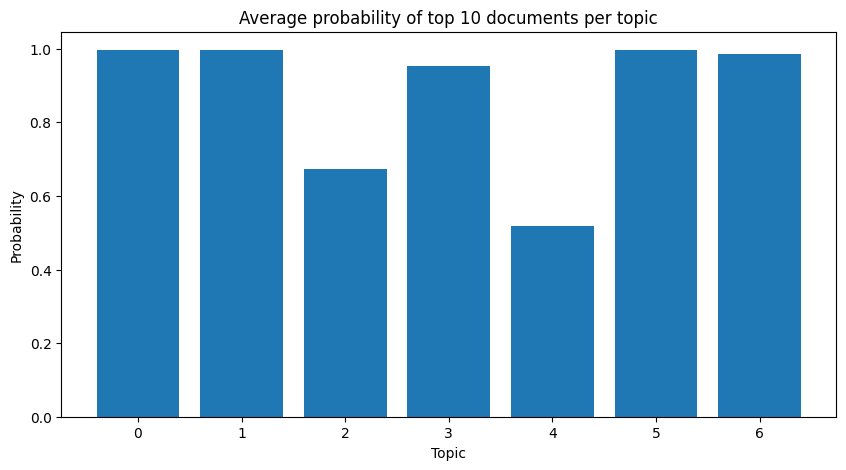

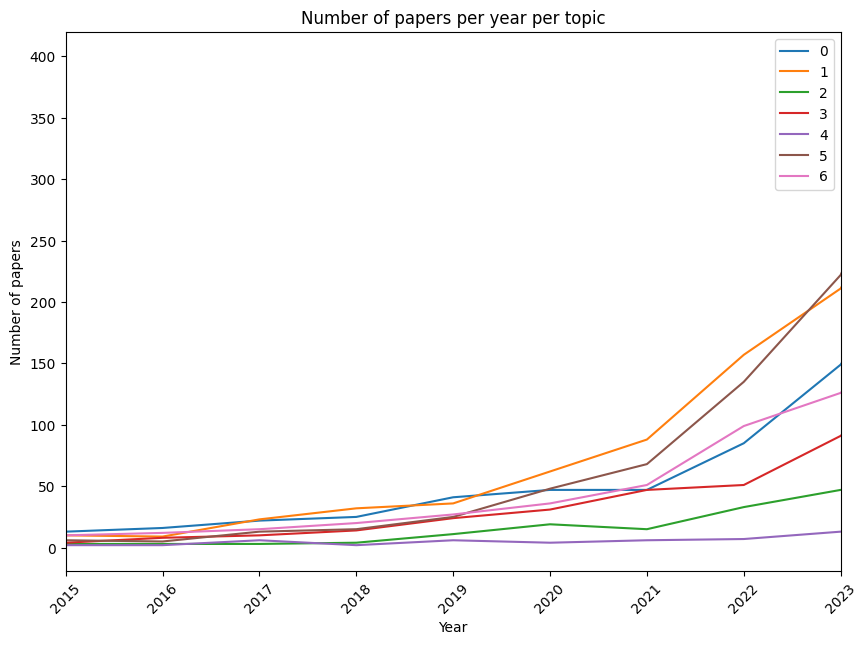

In [27]:
"""
Show the average probability of top 10 documents per topic
"""
plt.figure(figsize=(10,5))
plt.bar(range(0,number_of_topics),probabilities)
plt.title('Average probability of top 10 documents per topic')
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.xticks(range(0,number_of_topics))
plt.show()

"""
Show the number of papers per year per topic
"""
plt.figure(figsize=(10,7))
min_year = 2015
for i in range(len(topic_year)):
    topic_year[i] = {k: v for k, v in sorted(topic_year[i].items(), key=lambda item: item[0])}

for i in range(len(topic_year)):
    plt.plot(list(topic_year[i].keys()), list(topic_year[i].values()), label='Topic {}'.format(i))

plt.xlim(min_year,2023)
plt.xticks(range(min_year,2024), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of papers')
plt.title('Number of papers per year per topic')
plt.legend(range(number_of_topics))
plt.show()

## Print the top 10 papers per topic

### If you do not want to use open API for this part, you can just paste this part in ChatGPT with the prompt:

"These are the LDA top words for the topic `<your-topic>`, please give a possible topic area name for each group."

In [17]:
lda_model.print_topics(number_of_topics, num_words=20)

[(0,
  '0.017*"analysis" + 0.015*"sentiment" + 0.013*"data" + 0.010*"model" + 0.008*"study" + 0.008*"multimodal" + 0.007*"approach" + 0.007*"learning" + 0.007*"user" + 0.007*"social" + 0.007*"emotion" + 0.006*"medium" + 0.006*"review" + 0.006*"system" + 0.006*"research" + 0.005*"using" + 0.005*"technique" + 0.005*"text" + 0.004*"application" + 0.004*"video"'),
 (1,
  '0.029*"feature" + 0.025*"model" + 0.023*"sentiment" + 0.022*"multimodal" + 0.018*"analysis" + 0.015*"emotion" + 0.013*"fusion" + 0.012*"data" + 0.011*"information" + 0.010*"network" + 0.009*"proposed" + 0.009*"method" + 0.009*"text" + 0.009*"modality" + 0.009*"result" + 0.008*"classification" + 0.008*"video" + 0.007*"recognition" + 0.007*"audio" + 0.007*"accuracy"'),
 (2,
  '0.018*"task" + 0.015*"humor" + 0.011*"language" + 0.011*"meme" + 0.008*"emotion" + 0.007*"detection" + 0.007*"dataset" + 0.006*"medium" + 0.006*"sentiment" + 0.006*"corpus" + 0.006*"multimodal" + 0.006*"social" + 0.006*"challenge" + 0.006*"discourse" 

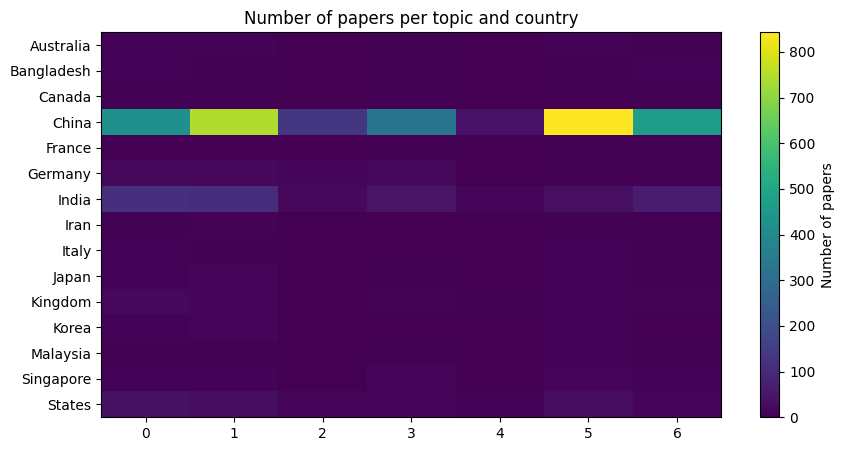

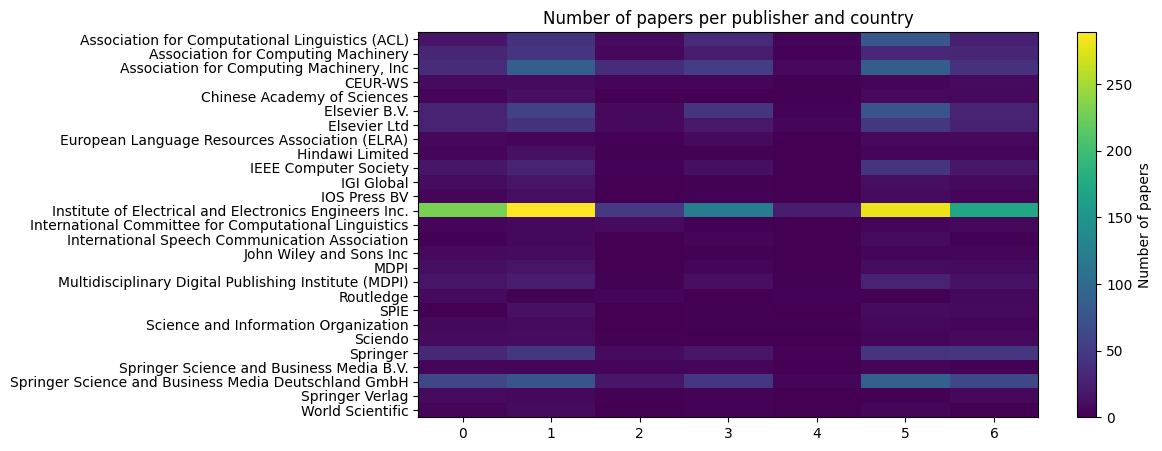

In [35]:

country_year_counts = final_topic_df.groupby(['Country', 'Topic']).size().unstack().fillna(0)
country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 20]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
plt.figure(figsize=(10,5))
plt.imshow(country_year_counts, aspect='auto')
plt.yticks(range(len(country_year_counts)), country_year_counts.index)
plt.xticks(range(len(country_year_counts.columns)), country_year_counts.columns)
plt.title('Number of papers per topic and country')
plt.colorbar(label='Number of papers')
plt.show()

country_year_counts = final_topic_df.groupby(['Publisher', 'Topic']).size().unstack().fillna(0)
country_year_counts = country_year_counts[country_year_counts.sum(axis=1) > 20]
country_year_counts = country_year_counts.reindex(sorted(country_year_counts.columns), axis=1)
plt.figure(figsize=(10,5))
plt.imshow(country_year_counts, aspect='auto')
plt.yticks(range(len(country_year_counts)), country_year_counts.index)
plt.xticks(range(len(country_year_counts.columns)), country_year_counts.columns)
plt.title('Number of papers per publisher and country')
plt.colorbar(label='Number of papers')
plt.show()


### The following are the results generated by ChatGPT according to the LDA result, it gives an overview of the current research trends in the field, and the potential future research directions.
### This is a useful tool for researchers to quickly understand the current state of the field and identify potential research gaps and opportunities.

Below is one possible way to label each topic based on the most prominent terms. Of course, naming is somewhat subjective—your specific research context may suggest slightly different labels:

1. **Topic 0:** *General Multimodal Sentiment Analysis Methods*  
   - Keywords suggest a broad overview: “analysis,” “sentiment,” “data,” “model,” “study,” “approach,” “learning,” “research,” “technique,” “text,” “video.”  
   - Likely encompasses foundational methods and general frameworks.

2. **Topic 1:** *Feature Fusion & Classification Approaches*  
   - Heavy emphasis on “feature,” “model,” “fusion,” “classification,” “accuracy,” “method,” “audio,” “video.”  
   - Suggests techniques for combining multiple modalities and building classification models.

3. **Topic 2:** *Humor, Meme, and Social-Media-Focused Tasks*  
   - Notable terms: “humor,” “meme,” “task,” “discourse,” “challenge,” “detection,” “social,” “dialogue.”  
   - Indicates work on specialized tasks (e.g., humor/meme detection) in social media contexts.

4. **Topic 3:** *Datasets & Research Challenges in Multimodal Sentiment Analysis*  
   - Terms such as “sentiment,” “analysis,” “multimodal,” “emotion,” “research,” “datasets,” “challenge.”  
   - Points to discussions of different data resources, benchmarks, and open problems in the field.

5. **Topic 4:** *Consumer Engagement & Advertising (Neuromarketing)*  
   - References to “video,” “advertisement,” “rating,” “viewer,” “product,” “consumer,” “eeg,” “prediction.”  
   - Suggests a focus on user/viewer reactions, possibly in marketing or user-experience studies.

6. **Topic 5:** *Representation Learning & Attention-Based Fusion*  
   - Strong presence of “multimodal,” “modality,” “representation,” “fusion,” “attention,” “performance,” “learning.”  
   - Points to modeling approaches that emphasize representation learning and advanced fusion mechanisms.

7. **Topic 6:** *Visual-Textual Social Media Sentiment*  
   - Key terms: “sentiment,” “image,” “text,” “analysis,” “social,” “medium,” “visual,” “opinion,” “classification.”  
   - Focus on integrating image and text data (e.g., posts, tweets, or other user-generated content).